## Libraries and Data

In [35]:
import math

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [36]:
df = pd.read_csv("../data/MSFT.csv")
df = df[["Date", "Close"]]
df["Date"] = pd.to_datetime(df["Date"])

In [37]:
df.head()

,Date,Close
0,2017-01-03,62.580002
1,2017-01-04,62.299999
2,2017-01-05,62.299999
3,2017-01-06,62.840000
4,2017-01-09,62.639999


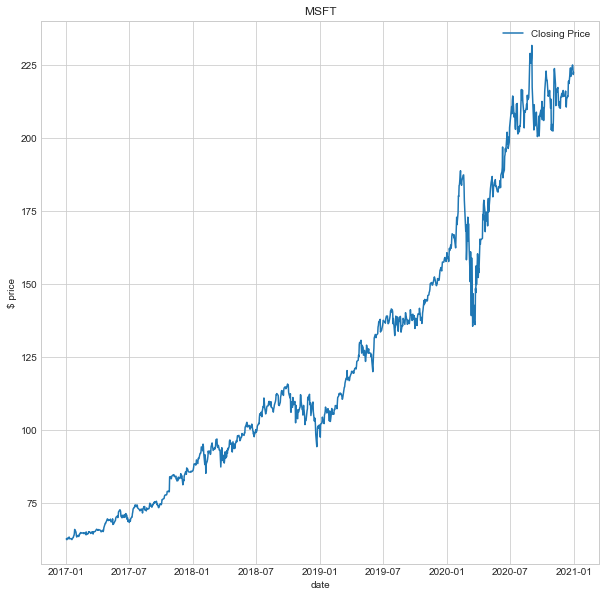

In [4]:
plt.figure(figsize=(10,10))

plt.plot(df["Date"], df["Close"], label="Closing Price")

plt.xlabel("date")  
plt.ylabel("$ price")  
plt.title("MSFT")

plt.legend()
plt.show()

In [ ]:
df["Close-1"] = df["Close"].shift(1)
df = df.drop([0])
df["Delta"] = df["Close"] - df["Close-1"]

In [ ]:
plt.figure(figsize=(10, 10))
sns.histplot(data=df, x="Delta")

## Baseline models

### Previous as predictor

In [ ]:
df["Close-1"] = df["Close"].shift(1)
df = df.drop([0])

In [ ]:
df.head()

In [ ]:
print(f"Prediction error: {math.sqrt(mean_squared_error(df['Close'], df['Close-1']))}")

### N-day moving average as predictor

In [ ]:
for i in [3, 5, 15, 30, 100]:
    df[f"MA-{i}"] = df["Close"].rolling(window=i).mean()
    
df = df.drop(df.index[:99])

In [ ]:
for i in [3, 5, 15, 30, 100]:
    print(f"Prediction error for MA-{i}: {math.sqrt(mean_squared_error(df['Close'], df[f'MA-{i}']))}")

## ARIMA, SARIMA

In [ ]:
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima.model import ARIMA

In [ ]:
plt.figure(figsize=(10,10))
autocorrelation_plot(df["Close"])

In [ ]:
size = int(len(df) * 0.66)
train, test = df[0:size]["Close"], df[size:len(df)]["Close"]

train = train.reset_index()["Close"]
test = test.reset_index()["Close"]

history = [x for x in train]

predictions = []

In [ ]:
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
print(f"Prediction error for ARIMA(5, 1, 0): {math.sqrt(mean_squared_error(test, predictions))}")

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(test, label="Real values")
plt.plot(predictions, color='red', label="Predicted values")

## Basic Machine Learning Models

### Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression

In [ ]:
df["Close-1"] = df["Close"].shift(1)
df = df.drop([0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Date", "Close"]),
    df["Close"],
    test_size=0.3,
    random_state=22
)

In [15]:
regression = LinearRegression()
model = regression.fit(X_train, y_train)

y_train_pred = regression.predict(X_train)
y_test_pred = regression.predict(X_test)
print(f"Training error: {math.sqrt(mean_squared_error(y_train, y_train_pred))}")
print(f"Test error: {math.sqrt(mean_squared_error(y_test, y_test_pred))}")

Training error: 2.7970120149346793
Test error: 2.740504098414068


## Deep Learning

### MLP

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import preprocessing

In [39]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [46]:
X, y = split_sequence(df["Close"], 3)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=22
)

val_size = int(len(X_train) * 0.66)
X_val = X_train[-val_size:]
X_train = X_train[:-val_size]
y_val = y_train[-val_size:]
y_train = y_train[:-val_size]

# standardizer = preprocessing.StandardScaler()
# standardizer.fit(X_train)
# X_train = standardizer.transform(X_train)
# X_val = standardizer.transform(X_val)
# X_test = standardizer.transform(X_test)

In [48]:
model = keras.Sequential(
    [
        layers.Dense(100, activation="relu", input_dim=3),
        layers.Dense(1)
    ]
)

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X, 
    y, 
    epochs=500,
    validation_data=(X_val, y_val),
    verbose=0
)

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [49]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(f"Training error MLP: {math.sqrt(mean_squared_error(y_train, y_train_pred))}")
print(f"Test error MLP: {math.sqrt(mean_squared_error(y_test, y_test_pred))}")

Training error MLP: 2.854055755996979
Test error MLP: 2.644910489969279
